In [52]:
import wave
from scipy import signal
import numpy as np
from matplotlib import pyplot as plt
from math import pi
%matplotlib inline

In [2]:
def read_wav(file):
    wf = wave.open(file, "r")
    framerate = wf.getframerate()
    x = wf.readframes(wf.getnframes())
    if wf.getsampwidth() == 2:
        x = np.frombuffer(x, dtype="int16") / 2 ** (wf.getsampwidth() * 8 - 1)
    elif wf.getsampwidth() == 4:
        x = np.frombuffer(x, dtype="int32") / 2 ** (wf.getsampwidth() * 8 - 1)
    else:
        print("サンプル幅が16bitか32bit以外でした。")
        return
    wf.close()
    print("----------------")
    print("wave Object: ", wf)
    # モノラル:1 ステレオ:2
    print("チャンネル数: ", wf.getnchannels())
    print("サンプリング周波数: ", wf.getframerate())
    print("フレーム数: ", wf.getnframes())
    print("サンプル幅: ", wf.getsampwidth())
    print("各パラメータ: ", wf.getparams())
    print("時間: ", wf.getnframes() / wf.getframerate())
    print("----------------")
    return x, framerate
filename = 'exam.wav'
wav, fs = read_wav(filename)

----------------
wave Object:  <wave.Wave_read object at 0x0000013D4E7342B0>
チャンネル数:  1
サンプリング周波数:  11025
フレーム数:  55296
サンプル幅:  2
各パラメータ:  _wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=55296, comptype='NONE', compname='not compressed')
時間:  5.015510204081632
----------------


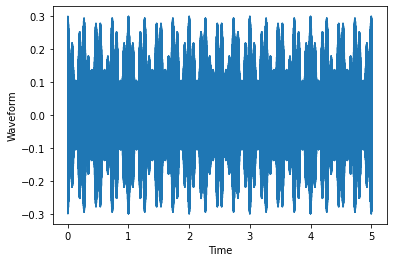

In [3]:
def data_plot(data, framerate):
    t = np.arange(0, len(data)) / framerate
    plt.xlabel("Time")
    plt.ylabel("Waveform")
    plt.plot(t, data)
    plt.show()

data_plot(wav, fs)

In [4]:
# 自己相関関数の算出
def autocorr(x, nlags=None):
    """自己相関関数を求める
    x:     信号
    nlags: 自己相関関数のサイズ（lag=0からnlags-1まで）
           引数がなければ（lag=0からlen(x)-1まですべて）
    """
    N = len(x)
    if nlags == None: nlags = N
    r = np.zeros(nlags)
    for lag in range(nlags):
        for n in range(N - lag):
            r[lag] += x[n] * x[n + lag]
    return r

def LevinsonDurbin(r, LPCOrder):
    """Levinson-Durbinのアルゴリズム
    k次のLPC係数からk+1次のLPC係数を再帰的に計算して
    LPC係数を求める"""
    # LPC係数（再帰的に更新される）
    # a[0]は1で固定のためlpcOrder個の係数を得るためには+1が必要
    a = np.zeros(LPCOrder + 1)
    e = np.zeros(LPCOrder + 1)

    # k = 1の場合
    a[0] = 1.0
    a[1] = - r[1] / r[0]
    e[1] = r[0] + r[1] * a[1]
    lam = - r[1] / r[0]

    # kの場合からk+1の場合を再帰的に求める
    for k in range(1, LPCOrder):
        # lambdaを更新
        lam = 0.0
        for j in range(k + 1):
            lam -= a[j] * r[k + 1 - j]
        lam /= e[k]

        # aを更新
        # UとVからaを更新
        U = [1]
        U.extend([a[i] for i in range(1, k + 1)])
        U.append(0)

        V = [0]
        V.extend([a[i] for i in range(k, 0, -1)])
        V.append(1)

        a = np.array(U) + lam * np.array(V)

        # eを更新
        e[k + 1] = e[k] * (1.0 - lam * lam)

    return a, e[-1]

def preEmphasis(signal, p):
    """プリエンファシスフィルタ"""
    # 係数 (1.0, -p) のFIRフィルタを作成
    return scipy.signal.lfilter([1.0, -p], 1, signal)


In [34]:
def plot_signal(s, a, e, fs, lpcOrder, file):
    t = np.arange(0.0, len(s) / fs, 1/fs)
    # LPCで前向き予測した信号を求める
    predicted = np.copy(s)
    # 過去lpcOrder分から予測するので開始インデックスはlpcOrderから
    # それより前は予測せずにオリジナルの信号をコピーしている
    for i in range(lpcOrder, len(predicted)):
        predicted[i] = 0.0
        for j in range(1, lpcOrder):
            predicted[i] -= a[j] * s[i - j]
    # オリジナルの信号をプロット
    plt.plot(t, s, label="original", color="c")
    # LPCで前向き予測した信号をプロット
    plt.plot(t, predicted, label="predict", color="r")
    plt.legend()
    plt.xlabel("Time (s)")
    plt.xlim((-0.001, t[-1]+0.001))
    plt.title(file)
    plt.grid()
    plt.show()

def plot_spectrum(s, a, e, fs, file, fft_list):
    # LPC係数の振幅スペクトルを求める
#     nfft = 2048   # FFTのサンプル数
#     fscale = np.fft.fftfreq(nfft, d = 1.0 / fs)[:nfft // 2]
    
    # オリジナル信号の対数スペクトル
#     spec = np.abs(np.fft.fft(s, nfft))
#     logspec = 20 * np.log10(spec)
#     plt.plot(fscale, logspec[:nfft // 2], label="original")
    
    for sample in fft_list:
        fscale = np.fft.fftfreq(sample, d = 1.0 / fs)[:sample // 2]
        # LPC対数スペクトル
        w, h = signal.freqz(np.sqrt(e), a, sample, "whole")
        lpcspec = np.abs(h)
        loglpcspec = 20 * np.log10(lpcspec)
        plt.plot(fscale, loglpcspec[:sample // 2], label="LPC: {}".format(sample), linewidth=2)

    plt.legend()
    plt.xlabel("Frequency (Hz)")
    plt.xlim((775, 825))
    plt.ylim((0, 50))
    plt.title(file)
    plt.grid()
    plt.show()

----------------
wave Object:  <wave.Wave_read object at 0x0000013D50BB69A0>
チャンネル数:  1
サンプリング周波数:  11025
フレーム数:  55296
サンプル幅:  2
各パラメータ:  _wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=55296, comptype='NONE', compname='not compressed')
時間:  5.015510204081632
----------------
r:  [ 833.66906314  747.18004855  505.67732423 ... -147.75572362  108.08497935
  342.62232667]
len(r):  2000
a:  [ 1.00000000e+00 -1.80975019e+00  1.02820412e+00 ... -1.78501853e-04
  7.17397261e-04 -9.33709238e-04]
len(a):  2000
e:  0.028925403302178365


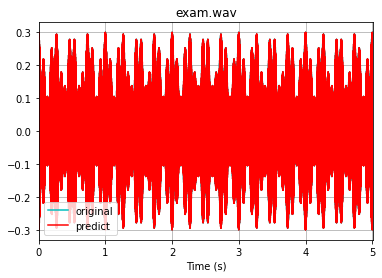

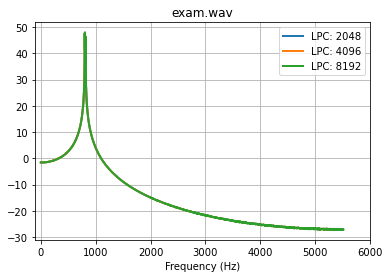

In [24]:
# parameters---------------------
LPCOrder = 1999
fft_list = [2048, 4096, 8192]
# -------------------------------
filename = 'exam.wav'
wav, fs = read_wav(filename)
t = np.arange(0, len(wav) / fs, 1 / fs)

# 自己相関関数の算出
r = autocorr(wav, LPCOrder + 1)
a, e  = LevinsonDurbin(r, LPCOrder)
print("r: ", r)
print("len(r): ", len(r))
print("a: ", a)
print("len(a): ", len(a))
print("e: ", e)

plot_signal(wav, a, e, fs, LPCOrder, filename)
plot_spectrum(wav, a, e, fs, filename, fft_list)

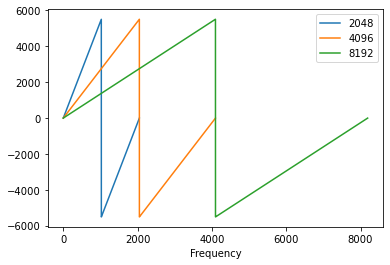

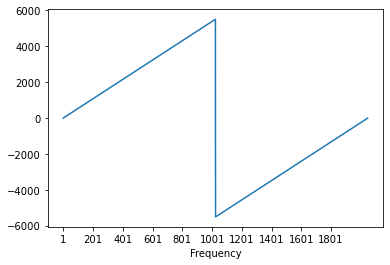

In [94]:
power_spectrum = np.fft.fft(r) # 変換結果
freq_1 = np.fft.fftfreq(2048, d=t[1]-t[0]) # 周波数
freq_2 = np.fft.fftfreq(4096, d=t[1]-t[0]) # 周波数
freq_3 = np.fft.fftfreq(8192, d=t[1]-t[0]) # 周波数

# fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(6,6))
# ax[0].plot(power_spectrum.real, label="Real part")
# ax[0].legend()
# ax[1].plot(power_spectrum.imag, label="Imaginary part")
# ax[1].legend()
# ax[2].plot(freq, label="Frequency")
# ax[2].legend()
# ax[2].set_xlabel("Number of data")

plt.plot(freq_1, label="2048")
plt.plot(freq_2, label="4096")
plt.plot(freq_3, label="8192")
plt.xlabel("Frequency")
plt.legend()

plt.show()

plt.plot(freq_1, label="2048")
plt.xticks(np.arange(1, 2000, 200))
plt.xlabel("Frequency")
plt.show()

C:\Users\kenta\anaconda3\envs\ImageRecovering\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


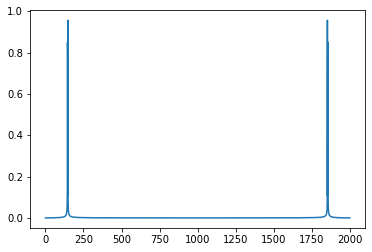

In [33]:
def power_spec_plot(data):
    data = abs(data) / max(data)
    plt.plot(data)
    plt.show()
power_spec_plot(power_spectrum)

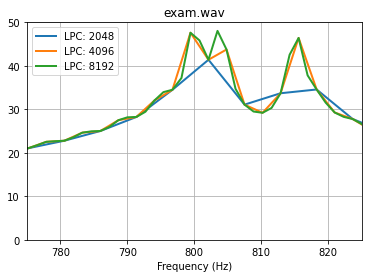

In [35]:
plot_spectrum(wav, a, e, fs, filename, fft_list)

In [80]:
def ar_power(f, a, t):
    jft = []
    for i in range(len(a)):
        jft.append(i)
    k = jft
    jft = np.array(jft)
    jft = -1 * len(a) * 2 * pi * f * t * jft
    jft = jft * k
    jft[0] = 1
    print(jft)
    
    exp = np.exp(jft)
    print(exp)
    
    sum = 0
    for p in range(1, len(a)):
        sum += a[p] * exp[p]
    print(sum)
    print(1 / np.square(1 + sum))
    return 1 / np.square(1 + sum)
    
ar_power(2048, a, t[1]-t[0])

[ 1.00000000e+00 -2.33432445e+03 -9.33729778e+03 ... -9.30930690e+09
 -9.31863253e+09 -9.32796282e+09]
[2.71828183 0.         0.         ... 0.         0.         0.        ]
0.0
1.0


1.0